In [1]:
### IMPORT PACKAGES ###
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import os
from PIL import Image, ImageFont, ImageDraw

In [2]:
### CAMERA CALIBRATION ###

# Arrays to store object points
objpoints = []
imgpoints = []

# Number of corners in x and y directions
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Prepare object points
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coordinates

# Iterate through each image
for filename in os.listdir("camera_cal/"):
    chess = mpimg.imread(os.path.join("camera_cal/", filename))    
    
    # Convert to grayscale
    gray_chess = cv2.cvtColor(chess, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray_chess, (nx, ny), None)
    
    if ret == True: # If corners are found, undistort the image
        # fill arrays
        imgpoints.append(corners)
        objpoints.append(objp)
        # Camera calibration given object points, image points, and the shape of the image
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, chess.shape[1:], None, None)
        # Undistort using mtx and dist
        undist_chess = cv2.undistort(chess, mtx, dist, None, mtx)
        #plt.figure()
        #plt.imshow(undist_chess)
        cv2.imwrite('output_images/' + filename, cv2.cvtColor(undist_chess,cv2.COLOR_BGR2RGB))
        


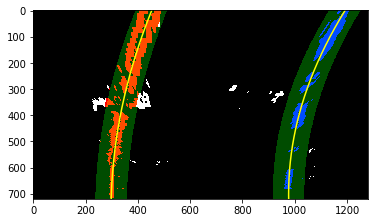

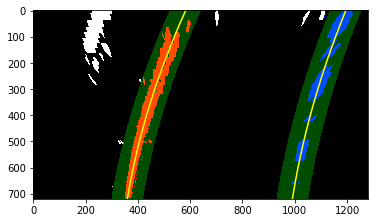

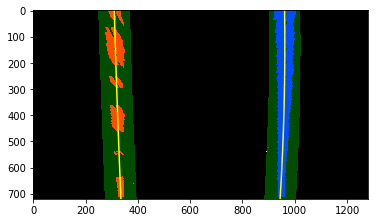

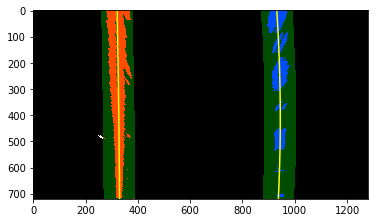

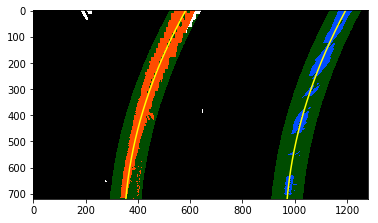

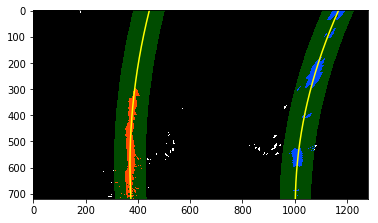

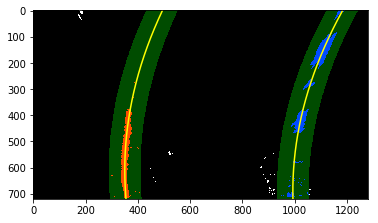

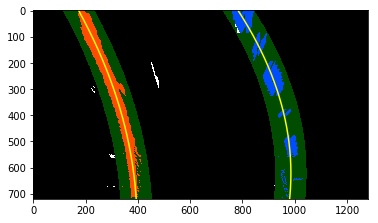

In [4]:
# Iterate through each image
for filename in os.listdir("test_images/"):
    img = mpimg.imread(os.path.join("test_images/", filename)) 
    
    ### IMAGE DISTORTION CORRECTION ###
    
    # Undistort using mtx and dist from camera calibration cell
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('output_images/undistorted_' + filename, cv2.cvtColor(undist,cv2.COLOR_BGR2RGB))
    #plt.figure()
    #plt.imshow(undist)
    
    #########################################
    
    
    ### COLOR TRANSFORMATION / GRADIENT ###

    # Convert to HLS Color Space
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient (green)
    thresh_min = 15
    thresh_max = 255
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel (blue)
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    #plt.figure()
    # Plotting thresholded images
    #f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
    #ax1.set_title('undistorted iamage')
    #ax1.imshow(undist)
    #ax2.set_title('Stacked thresholds')
    #ax2.imshow(color_binary)
    #ax3.set_title('Combined S channel and gradient thresholds')
    #ax3.imshow(combined_binary * 255, cmap = 'gray')
    
    cv2.imwrite('output_images/binary_' + filename, combined_binary * 255)
    
    #########################################
    
    
    ### PERSPECTIVE TRANSFORMATION ###
  
    xsize = undist.shape[1]
    ysize = undist.shape[0]
    src = np.float32([(180,ysize),(595,450), (688,450), (1125,ysize)])
    # Choose destination points
    dst = np.float32([(310,ysize), (310,0), (960,0), (960,ysize)])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # first the color images...
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undist, M, (xsize,ysize))
    # Draw straight lines on warped image
    vertices_warp = np.array([[(310,ysize), (310,0), (960,0), (960,ysize)]], dtype=np.int32)
    contour_image_warp = np.copy(undist)*0 # creating a blank to draw lines on
    cv2.drawContours(contour_image_warp, vertices_warp, 0, (255,0,0), 3)
    lines_on_warped = cv2.addWeighted(warped, 1, contour_image_warp, 1, 0.)
    
    # Draw the trapezoidal contour on the undistorted image
    vertices_trap = np.array([[(180,ysize),(592,450), (687,450), (1135,ysize)]], dtype=np.int32)
    contour_image_trap = np.copy(undist)*0 # creating a blank to draw lines on
    cv2.drawContours(contour_image_trap, vertices_trap, 0, (255,0,0), 3)
    trap_on_original = cv2.addWeighted(undist, 1, contour_image_trap, 1, 0.)

    #plt.figure()
    # Plotting warped images
    #f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
    #ax1.set_title('Undistorted Image')
    #ax1.imshow(undist)
    #ax2.set_title('Trapezoid')
    #ax2.imshow(trap_on_original)
    #ax3.set_title('Warped Image')
    #ax3.imshow(lines_on_warped)

    cv2.imwrite('output_images/warped_' + filename, cv2.cvtColor(lines_on_warped,cv2.COLOR_BGR2RGB))
    
    # Now for the binary images...
    
    combined_binary_rgb = cv2.cvtColor(combined_binary, cv2.COLOR_GRAY2RGB)*255

    # warp the image
    warped_binary = cv2.warpPerspective(combined_binary_rgb, M, (xsize,ysize))
    # Draw straight lines on warped image
    contour_image_warp = np.copy(undist)*0 # creating a blank to draw lines on
    cv2.drawContours(contour_image_warp, vertices_warp, 0, (255,0,0), 3)
    lines_on_warped_binary = cv2.addWeighted(warped_binary, 1, contour_image_warp, 1, 0.)
    
    # Draw the trapezoidal contour on the undistorted binary image
    contour_image_trap = np.copy(undist)*0 # creating a blank to draw lines on
    cv2.drawContours(contour_image_trap, vertices_trap, 0, (255,0,0), 3)
    trap_on_binary = cv2.addWeighted(combined_binary_rgb, 1, contour_image_trap, 1, 0.)
    
    #plt.figure()
    # Plotting warped images
    #f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
    #ax1.set_title('Undistorted Binary Image')
    #ax1.imshow(combined_binary_rgb)
    #ax2.set_title('Trapezoid')
    #ax2.imshow(trap_on_binary)
    #ax3.set_title('Warped Image')
    #ax3.imshow(lines_on_warped_binary)
    
    cv2.imwrite('output_images/warped_binary_' + filename, cv2.cvtColor(lines_on_warped_binary,cv2.COLOR_BGR2RGB))
    
    
    #########################################
    
    ### PIXEL IDENTIFICATION ###
    
    ### MASK REGION ###
    # create polygon that includes the lane lines
    top_of_lane = int(0.625*ysize) # y position of endpoint of lane lines
    vertices = np.array([[(int(.115*xsize),ysize),(int(.45*xsize), top_of_lane), (int(.567*xsize), top_of_lane), (int(0.984*xsize),ysize), (int(0.828*xsize),ysize), (int(.53*xsize),int(2/3*ysize)),(int(.498*xsize),int(2/3*ysize)),(int(.28*xsize),ysize)]], dtype=np.int32)
    #defining a blank mask to start with
    mask = np.zeros_like(combined_binary)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where massolidWhiteCurvek pixels are nonzero
    masked_image = cv2.bitwise_and(combined_binary, mask)
    #plt.figure()
    #plt.imshow(masked_image, cmap='gray')
    # Draw the trapezoidal contour on the undistorted binary image (for debugging)
    contour_image = np.copy(combined_binary_rgb)*0 # creating a blank to draw lines on
    cv2.drawContours(contour_image, vertices, 0, (255,0,0), 3)
    trap_on_binary = cv2.addWeighted(combined_binary_rgb, 1, contour_image, 1, 0.)
    #plt.figure()
    #plt.imshow(trap_on_binary)
    
    # warp the image
    warped_binary = cv2.warpPerspective(masked_image, M, (xsize,ysize))
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(warped_binary.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary.shape[0] - (window+1)*window_height
        win_y_high = warped_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Searching from prior...
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    lane_lines = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    plt.figure()
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    # View your output
    plt.imshow(lane_lines)
    plt.savefig('output_images/lane_lines_' + filename, bbox_inches='tight')

    #########################################
    

    ### MEASURING CURVATURE ###
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/650 # meters per pixel in x dimension

    # New lines in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calc both polynomials using ploty, left_fit_cr and right_fit_cr ###
    left_fit_crx = left_fit_cr[0]*ploty**2 + left_fit_cr[1]*ploty + left_fit_cr[2]
    right_fit_crx = right_fit_cr[0]*ploty**2 + right_fit_cr[1]*ploty + right_fit_cr[2]
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresimgponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    # Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**(3/2)/abs(2*left_fit_cr[0])
    right_curverad = (1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**(3/2)/abs(2*right_fit_cr[0])
    rac = (left_curverad+right_curverad)/2
    lane_midpoint = (left_fitx + right_fitx)/2 # create line at midpoint of lane
    
    # Find vehicle position relative to middle of lane
    lateral_offset = (lane_midpoint[-1] - warped_binary.shape[1]/2) * xm_per_pix
        
    #########################################
        
        
    ### UNWARPING THE FINAL IMAGE ###
    
    # Create an image to draw on and an image to show the lane window
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    window_img = np.zeros_like(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
    all_pts = np.hstack((left_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([all_pts]), (0,255, 0))
    
    # Color in left and right line pixels
    window_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    window_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    window_img_unwarped = cv2.warpPerspective(window_img, Minv, (xsize,ysize))
    final = cv2.addWeighted(img,1,window_img_unwarped,0.3,0)
    
    # Display Radius of Curvature and Vehicle Lateral Position
    message1 = ('Radius of Curvature = {}m'.format(int(rac)))
    if lateral_offset < 0:
        message2 = ("Vehicle is {}m left of center".format(str(round(lateral_offset,3))))
    else:
        message2 = ("Vehicle is {}m right of center".format(str(round(lateral_offset,3))))
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
    # org 
    org1 = (50, 50)
    org2 = (50, 100)
    # fontScale 
    fontScale = 2
    # Blue color in BGR 
    color = (255, 255, 255) 
    # Line thickness of 2 px 
    thickness = 3
    cv2.putText(final, message1, org1, font, fontScale, color, thickness, cv2.LINE_AA) 
    cv2.putText(final, message2, org2, font, fontScale, color, thickness, cv2.LINE_AA) 

    #plt.figure()
    #plt.imshow(final)
    cv2.imwrite('output_images/final_' + filename, cv2.cvtColor(final,cv2.COLOR_BGR2RGB))
    
    #########################################


In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

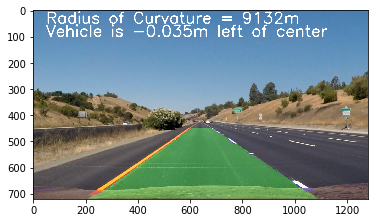

In [6]:
def process_image(img):
    
    ### IMAGE DISTORTION CORRECTION ###
    
    # Undistort using mtx and dist from camera calibration cell
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    #########################################
    
    ### COLOR TRANSFORMATION / GRADIENT ###

    # Convert to HLS Color Space
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient (green)
    thresh_min = 15
    thresh_max = 255
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel (blue)
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    
    #########################################
    
    ### PERSPECTIVE TRANSFORMATION ###
  
    xsize = undist.shape[1]
    ysize = undist.shape[0]
    src = np.float32([(180,ysize),(595,450), (688,450), (1125,ysize)])
    # Choose destination points
    dst = np.float32([(310,ysize), (310,0), (960,0), (960,ysize)])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    
    # first the color images...
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undist, M, (xsize,ysize))
    # Draw straight lines on warped image
    vertices_warp = np.array([[(310,ysize), (310,0), (960,0), (960,ysize)]], dtype=np.int32)
    contour_image_warp = np.copy(undist)*0 # creating a blank to draw lines on
    cv2.drawContours(contour_image_warp, vertices_warp, 0, (255,0,0), 3)
    lines_on_warped = cv2.addWeighted(warped, 1, contour_image_warp, 1, 0.)
    
    # Draw the trapezoidal contour on the undistorted image
    vertices_trap = np.array([[(180,ysize),(592,450), (687,450), (1135,ysize)]], dtype=np.int32)
    contour_image_trap = np.copy(undist)*0 # creating a blank to draw lines on
    cv2.drawContours(contour_image_trap, vertices_trap, 0, (255,0,0), 3)
    trap_on_original = cv2.addWeighted(undist, 1, contour_image_trap, 1, 0.)
    
    
    # Now for the binary images...
    
    combined_binary_rgb = cv2.cvtColor(combined_binary, cv2.COLOR_GRAY2RGB)*255

    # warp the image
    warped_binary = cv2.warpPerspective(combined_binary_rgb, M, (xsize,ysize))
    # Draw straight lines on warped image
    contour_image_warp = np.copy(undist)*0 # creating a blank to draw lines on
    cv2.drawContours(contour_image_warp, vertices_warp, 0, (255,0,0), 3)
    lines_on_warped_binary = cv2.addWeighted(warped_binary, 1, contour_image_warp, 1, 0.)
    
    # Draw the trapezoidal contour on the undistorted binary image
    contour_image_trap = np.copy(undist)*0 # creating a blank to draw lines on
    cv2.drawContours(contour_image_trap, vertices_trap, 0, (255,0,0), 3)
    trap_on_binary = cv2.addWeighted(combined_binary_rgb, 1, contour_image_trap, 1, 0.)
    
    
    #########################################
    
    ### PIXEL IDENTIFICATION ###
    
    ### MASK REGION ###
    # create polygon that includes the lane lines
    top_of_lane = int(0.625*ysize) # y position of endpoint of lane lines
    vertices = np.array([[(int(.115*xsize),ysize),(int(.45*xsize), top_of_lane), (int(.567*xsize), top_of_lane), (int(0.984*xsize),ysize), (int(0.828*xsize),ysize), (int(.53*xsize),int(2/3*ysize)),(int(.498*xsize),int(2/3*ysize)),(int(.28*xsize),ysize)]], dtype=np.int32)
    #defining a blank mask to start with
    mask = np.zeros_like(combined_binary)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where massolidWhiteCurvek pixels are nonzero
    masked_image = cv2.bitwise_and(combined_binary, mask)
    # Draw the trapezoidal contour on the undistorted binary image (for debugging)
    contour_image = np.copy(combined_binary_rgb)*0 # creating a blank to draw lines on
    cv2.drawContours(contour_image, vertices, 0, (255,0,0), 3)
    trap_on_binary = cv2.addWeighted(combined_binary_rgb, 1, contour_image, 1, 0.)
    
    # warp the image
    warped_binary = cv2.warpPerspective(masked_image, M, (xsize,ysize))
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(warped_binary.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary.shape[0] - (window+1)*window_height
        win_y_high = warped_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Searching from prior...
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Measuring curvature ...
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/650 # meters per pixel in x dimension

    # New lines in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calc both polynomials using ploty, left_fit_cr and right_fit_cr ###
    left_fit_crx = left_fit_cr[0]*ploty**2 + left_fit_cr[1]*ploty + left_fit_cr[2]
    right_fit_crx = right_fit_cr[0]*ploty**2 + right_fit_cr[1]*ploty + right_fit_cr[2]
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresimgponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    # Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**(3/2)/abs(2*left_fit_cr[0])
    right_curverad = (1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**(3/2)/abs(2*right_fit_cr[0])
    rac = (left_curverad+right_curverad)/2
    lane_midpoint = (left_fitx + right_fitx)/2 # create line at midpoint of lane
    
    # Find vehicle position relative to middle of lane
    lateral_offset = (lane_midpoint[-1] - warped_binary.shape[1]/2) * xm_per_pix
        
    #########################################
        
        
    ### UNWARPING THE FINAL IMAGE ###
    
    # Create an image to draw on and an image to show the lane window
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    window_img = np.zeros_like(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
    all_pts = np.hstack((left_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([all_pts]), (0,255, 0))
    
    # Color in left and right line pixels
    window_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    window_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    window_img_unwarped = cv2.warpPerspective(window_img, Minv, (xsize,ysize))
    final = cv2.addWeighted(img,1,window_img_unwarped,0.3,0)
    
    # Display Radius of Curvature and Vehicle Lateral Position
    message1 = ('Radius of Curvature = {}m'.format(int(rac)))
    if lateral_offset < 0:
        message2 = ("Vehicle is {}m left of center".format(str(round(lateral_offset,3))))
    else:
        message2 = ("Vehicle is {}m right of center".format(str(round(lateral_offset,3))))
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
    # org 
    org1 = (50, 50)
    org2 = (50, 100)
    # fontScale 
    fontScale = 2
    # Blue color in BGR 
    color = (255, 255, 255) 
    # Line thickness of 2 px 
    thickness = 3
    cv2.putText(final, message1, org1, font, fontScale, color, thickness, cv2.LINE_AA) 
    cv2.putText(final, message2, org2, font, fontScale, color, thickness, cv2.LINE_AA) 
    
    return final

process_image(mpimg.imread(os.path.join("test_images/straight_lines1.jpg")))
plt.imshow(process_image(mpimg.imread(os.path.join("test_images/straight_lines1.jpg"))))

In [7]:
test_video_output = 'my_project_video.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip('project_video.mp4')
test_clip = clip1.fl_image(process_image) 
%time test_clip.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video my_project_video.mp4
[MoviePy] Writing video my_project_video.mp4


100%|█████████▉| 1260/1261 [05:21<00:00,  3.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_project_video.mp4 

CPU times: user 3min 6s, sys: 13.6 s, total: 3min 19s
Wall time: 5min 24s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video_output))